# Plant Pathology Training Notebook

In [1]:
from fastai.vision.all import *
torch.cuda.set_device(1)

seed = 42
set_seed(seed, reproducible=True)

%config Completer.use_jedi = False
%matplotlib inline

Set hyperparameters for the notebook here:

In [2]:
# Hyperparameters
valid_pct = 0.2

In [3]:
path = Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/')
path.ls()

(#5) [Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/train_images'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/test_images'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/sample_submission.csv'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/plant-pathology-2021-fgvc8.zip'),Path('/media/xar/barracuda1/fast.ai/data/plant_pathology/train.csv')]

In [4]:
Path.BASE_PATH = path

In [5]:
(path/'train_images').ls()

(#18632) [Path('train_images/d7707b87601e9721.jpg'),Path('train_images/f1c0918f0b1ff4d8.jpg'),Path('train_images/9fd08acafc84e664.jpg'),Path('train_images/d4eccc89612723b7.jpg'),Path('train_images/bc287d94706dd853.jpg'),Path('train_images/90fc3c90d72f05f4.jpg'),Path('train_images/b5d7d2cdcf0d0c04.jpg'),Path('train_images/e07485de9fbca409.jpg'),Path('train_images/a7b91490d7de5a82.jpg'),Path('train_images/dce254af368e2658.jpg')...]

In [6]:
(path/'test_images').ls()

(#3) [Path('test_images/c7b03e718489f3ca.jpg'),Path('test_images/85f8cb619c66b863.jpg'),Path('test_images/ad8770db05586b59.jpg')]

The labels of the training images are in `train.csv` which has a space delimited list of labels for each image.

In [7]:
df = pd.read_csv(path/'train.csv')
df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [8]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(540, min_scale=0.35)
)

# dsets = dblock.datasets(df)
# dsets.train[0]
dls = dblock.dataloaders(df)
# dls.show_batch(nrows=1, ncols=3)

In [9]:
learn = cnn_learner(dls, arch=resnet18)

/home/xar/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
x,y = to_cpu(dls.train.one_batch())
activations = learn.model(x)
activations.shape

torch.Size([64, 22])

In [11]:
activations[0]

tensor([-0.8879, -2.5526, -1.0573,  4.0817, -0.6218, -2.6610,  0.5779,  3.6589,
        -0.7747, -0.2502,  2.6836, -0.7322, -1.2259,  0.5110, -1.3524, -3.0034,
         0.9597, -1.3111,  5.3935, -3.0109,  0.1775,  2.6457],
       grad_fn=<SelectBackward>)

In [12]:
loss_func = nn.BCEWithLogitsLoss()

In [13]:
loss_func(activations, y)

TensorMultiCategory(1.0917, grad_fn=<AliasBackward>)

# Valid Loss

### Fine-tune a Resnet18

SuggestedLRs(valley=0.0020892962347716093)

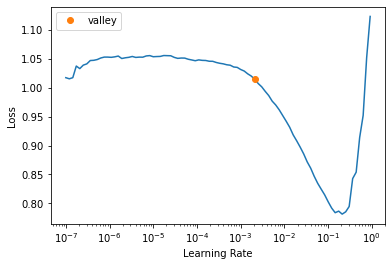

In [14]:
dls = dblock.dataloaders(df, bs=64)

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet18_vl_540px'
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.567183,0.349798,0.730259,13:02
1,0.264659,0.207821,0.817706,14:21


Better model found at epoch 0 with valid_loss value: 0.34979769587516785.


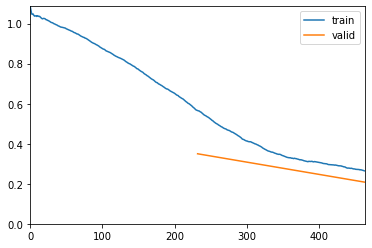

Better model found at epoch 1 with valid_loss value: 0.20782101154327393.


epoch,train_loss,valid_loss,f1_score,time
0,0.193892,0.150492,0.861315,13:40
1,0.162274,0.134307,0.872195,13:10
2,0.138689,0.132943,0.884632,13:02
3,0.126192,0.118262,0.890395,13:00
4,0.108101,0.124983,0.890070,12:57
5,0.092193,0.123378,0.888222,12:59
6,0.073864,0.118063,0.899462,12:58
7,0.060536,0.121166,0.901823,12:59
8,0.046608,0.117316,0.909411,12:57
9,0.047058,0.120180,0.909998,12:57


Better model found at epoch 0 with valid_loss value: 0.15049156546592712.


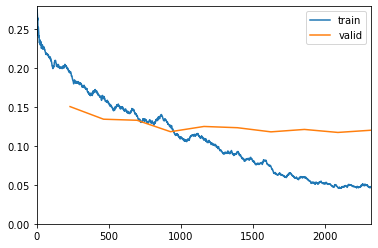

Better model found at epoch 1 with valid_loss value: 0.13430684804916382.
Better model found at epoch 2 with valid_loss value: 0.13294285535812378.
Better model found at epoch 3 with valid_loss value: 0.11826231330633163.
Better model found at epoch 6 with valid_loss value: 0.11806345731019974.
Better model found at epoch 8 with valid_loss value: 0.11731618642807007.


In [15]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=2)

In [16]:
learn.export('plant_resnet18_vl_540px.pkl') # save the model

In [17]:
learn = load_learner('plant_resnet18_vl_540px.pkl') # load the model

### Fine-tune a Resnet34

SuggestedLRs(valley=0.0020892962347716093)

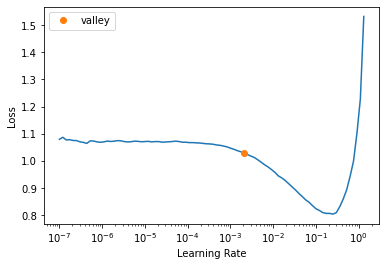

In [18]:
dls = dblock.dataloaders(df, bs=64)

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet34_vl_540px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.580514,0.351660,0.734982,13:15
1,0.265811,0.201768,0.818648,13:20


Better model found at epoch 0 with valid_loss value: 0.3516599237918854.


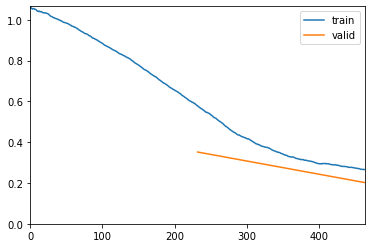

Better model found at epoch 1 with valid_loss value: 0.20176760852336884.


epoch,train_loss,valid_loss,f1_score,time
0,0.178136,0.141225,0.865777,14:41
1,0.156462,0.128408,0.886665,14:41
2,0.143677,0.124630,0.888305,14:40
3,0.126435,0.124600,0.890626,14:41
4,0.103433,0.113931,0.897154,14:40
5,0.083935,0.117203,0.905906,14:41
6,0.067947,0.120438,0.907207,14:41
7,0.053776,0.126037,0.909191,14:41
8,0.041077,0.130850,0.912826,14:40
9,0.037109,0.130131,0.912637,15:30


Better model found at epoch 0 with valid_loss value: 0.1412246972322464.


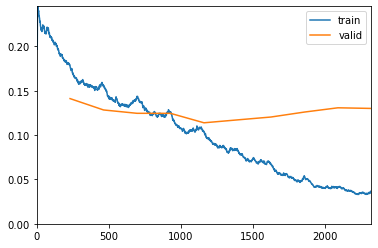

Better model found at epoch 1 with valid_loss value: 0.12840834259986877.
Better model found at epoch 2 with valid_loss value: 0.12463008612394333.
Better model found at epoch 3 with valid_loss value: 0.12459971755743027.
Better model found at epoch 4 with valid_loss value: 0.113930843770504.


In [19]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=2)

In [20]:
learn.export('plant_resnet34_vl_540px.pkl') # save the model

In [21]:
learn = load_learner('plant_resnet34_vl_540px.pkl') # load the model

### Fine-tune a Resnet50

SuggestedLRs(valley=0.002511886414140463)

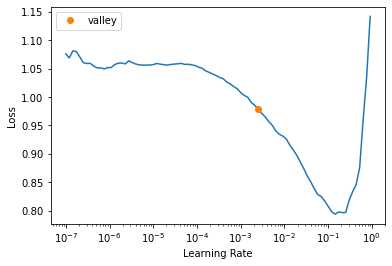

In [22]:
dls = dblock.dataloaders(df, bs=40)

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet50_vl_540px'
                     
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.365380,0.217899,0.811518,17:01
1,0.215116,0.151630,0.853386,16:51


Better model found at epoch 0 with valid_loss value: 0.2178986519575119.


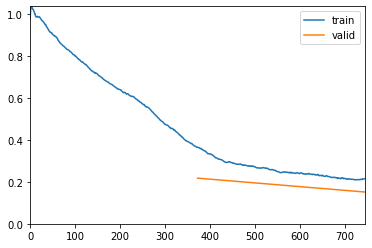

Better model found at epoch 1 with valid_loss value: 0.15163010358810425.


epoch,train_loss,valid_loss,f1_score,time
0,0.154603,0.120737,0.892450,21:35
1,0.138730,0.126412,0.882808,21:32
2,0.153158,0.122860,0.878707,21:33
3,0.135183,0.110230,0.896849,21:32
4,0.124722,0.117107,0.886478,21:59
5,0.095686,0.106363,0.913123,21:39
6,0.087740,0.095249,0.916069,21:56
7,0.060941,0.101509,0.919255,22:02
8,0.052861,0.100887,0.924247,21:40
9,0.044528,0.103407,0.923595,21:32


Better model found at epoch 0 with valid_loss value: 0.12073684483766556.


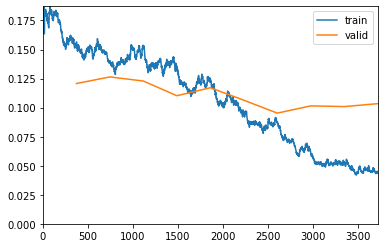

Better model found at epoch 3 with valid_loss value: 0.11023032665252686.
Better model found at epoch 5 with valid_loss value: 0.10636279731988907.
Better model found at epoch 6 with valid_loss value: 0.09524949640035629.


In [23]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=2)

In [24]:
learn.export('plant_resnet50_vl_540px.pkl') # save the model

In [25]:
learn = load_learner('plant_resnet50_vl_540px.pkl') # load the model

### Fine-tune a Resnet101

SuggestedLRs(valley=0.0006918309954926372)

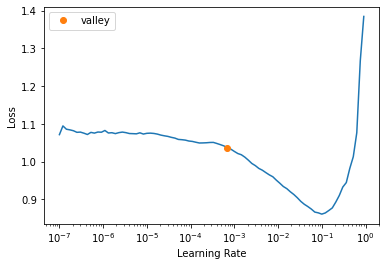

In [26]:
dls = dblock.dataloaders(df, bs=26)

learn = cnn_learner(dls,
                    arch=resnet101,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet101_vl_540px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.516599,0.362004,0.729145,24:26
1,0.245021,0.183446,0.836516,24:28


Better model found at epoch 0 with valid_loss value: 0.36200398206710815.


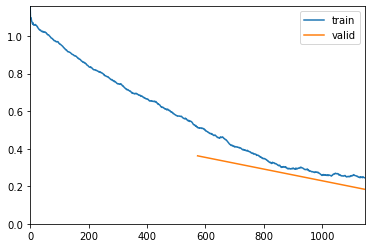

Better model found at epoch 1 with valid_loss value: 0.18344630300998688.


epoch,train_loss,valid_loss,f1_score,time
0,0.191591,0.130224,0.883948,32:31
1,0.154086,0.118160,0.900814,32:43
2,0.148760,0.123098,0.893566,32:46
3,0.132318,0.111943,0.904742,32:34
4,0.111718,0.109905,0.898169,32:30
5,0.091781,0.104497,0.913653,32:31
6,0.066725,0.111239,0.910886,32:30
7,0.054734,0.109738,0.918409,32:29
8,0.047302,0.113580,0.915310,32:30
9,0.043618,0.118214,0.912970,32:31


Better model found at epoch 0 with valid_loss value: 0.13022367656230927.


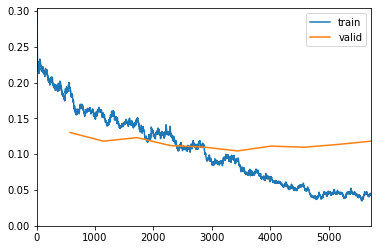

Better model found at epoch 1 with valid_loss value: 0.11816045641899109.
Better model found at epoch 3 with valid_loss value: 0.11194340884685516.
Better model found at epoch 4 with valid_loss value: 0.10990484058856964.
Better model found at epoch 5 with valid_loss value: 0.10449706017971039.


In [27]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=2)

In [28]:
learn.export('plant_resnet101_vl_540px.pkl') # save the model

In [29]:
learn = load_learner('plant_resnet101_vl_540px.pkl') # load the model

### Resnet152

In [30]:
dls = dblock.dataloaders(df, bs=20)

learn = cnn_learner(dls,
                    arch=resnet152,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet152_vl_540px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

RuntimeError: CUDA out of memory. Tried to allocate 46.00 MiB (GPU 1; 11.93 GiB total capacity; 10.41 GiB already allocated; 28.94 MiB free; 11.21 GiB reserved in total by PyTorch)

In [ ]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=2)

In [ ]:
learn.export('plant_resnet152_vl_540px.pkl') # save the model

In [ ]:
learn = load_learner('plant_resnet152_vl_540px.pkl') # load the model

### Parallel test

In [15]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.vision.models.xresnet import *

# path = rank0_first(untar_data, URLs.IMAGEWOOF_320)
# dls = DataBlock(
#     blocks=(ImageBlock, CategoryBlock),
#     splitter=GrandparentSplitter(valid_name='val'),
#     get_items=get_image_files, get_y=parent_label,
#     item_tfms=[RandomResizedCrop(160), FlipItem(0.5)],
#     batch_tfms=Normalize.from_stats(*imagenet_stats)
# ).dataloaders(path, path=path, bs=64)
dls = dblock.dataloaders(df, bs=128)

# learn = Learner(dls, xresnet50(n_out=10), metrics=[accuracy,top_k_accuracy]).to_native_fp16()
learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5)
                   )

In [16]:
with learn.distrib_ctx(): learn.fine_tune(4, 3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,f1_score,time


RuntimeError: CUDA out of memory. Tried to allocate 570.00 MiB (GPU 0; 11.92 GiB total capacity; 10.58 GiB already allocated; 187.50 MiB free; 11.04 GiB reserved in total by PyTorch)

# F1 callback

## resnet18

SuggestedLRs(valley=0.0010000000474974513)

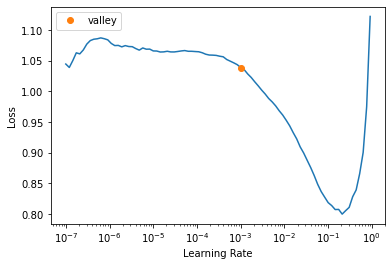

In [14]:
dls = dblock.dataloaders(df, bs=64)

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='f1_score',
                            fname='resnet18_f1_540px'
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.818241,0.599510,0.557821,12:42
1,0.521190,0.360846,0.734158,12:37
2,0.307743,0.232644,0.800741,12:35
3,0.251579,0.200811,0.823962,12:31


Better model found at epoch 0 with f1_score value: 0.5578207754097482.


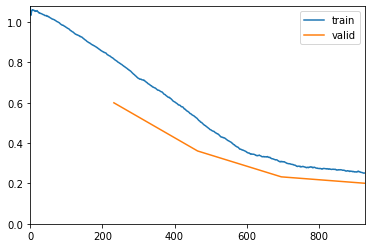

Better model found at epoch 1 with f1_score value: 0.7341575810969361.
Better model found at epoch 2 with f1_score value: 0.8007409437640369.
Better model found at epoch 3 with f1_score value: 0.8239616698647464.


epoch,train_loss,valid_loss,f1_score,time
0,0.204628,0.167817,0.851084,12:42
1,0.171543,0.142253,0.866574,12:40
2,0.152988,0.137001,0.869712,12:39
3,0.131625,0.122876,0.886822,12:39
4,0.116275,0.122386,0.888947,12:39
5,0.104499,0.117398,0.896598,12:39
6,0.088460,0.114924,0.903198,12:42
7,0.078669,0.116192,0.898665,12:40
8,0.074787,0.115750,0.903215,12:39
9,0.069570,0.115896,0.900838,12:34


Better model found at epoch 0 with f1_score value: 0.851083878205186.


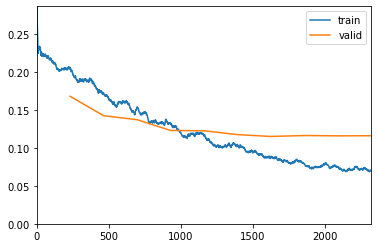

Better model found at epoch 1 with f1_score value: 0.8665738264639494.
Better model found at epoch 2 with f1_score value: 0.8697121994585711.
Better model found at epoch 3 with f1_score value: 0.8868223630032092.
Better model found at epoch 4 with f1_score value: 0.8889468015463154.
Better model found at epoch 5 with f1_score value: 0.8965982054332737.
Better model found at epoch 6 with f1_score value: 0.9031981275007795.
Better model found at epoch 8 with f1_score value: 0.9032151476870756.


In [15]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [16]:
learn.export('plant_resnet18_f1_540px.pkl') # save the model

In [17]:
learn = load_learner('plant_resnet18_f1_540px.pkl') # load the model

# resnet34

SuggestedLRs(valley=0.0008317637839354575)

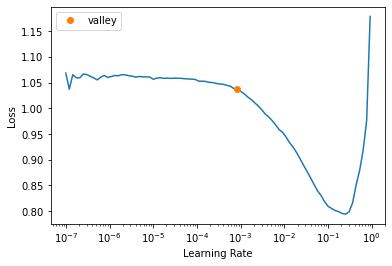

In [18]:
dls = dblock.dataloaders(df, bs=64)

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='f1_score',
                            fname='resnet34_f1_540px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.841465,0.599885,0.551607,12:47
1,0.560319,0.375179,0.728645,12:43
2,0.327000,0.237399,0.801923,12:43
3,0.257560,0.200277,0.835062,12:40


Better model found at epoch 0 with f1_score value: 0.5516065881459076.


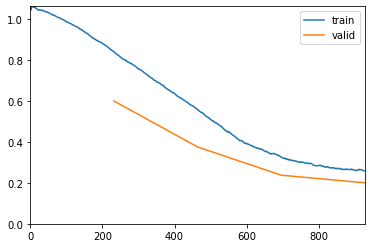

Better model found at epoch 1 with f1_score value: 0.728644923316996.
Better model found at epoch 2 with f1_score value: 0.8019227919879064.
Better model found at epoch 3 with f1_score value: 0.8350620013432652.


epoch,train_loss,valid_loss,f1_score,time
0,0.200323,0.154476,0.858593,12:52
1,0.167157,0.131448,0.881394,12:51
2,0.148072,0.118640,0.890009,12:55
3,0.123499,0.123477,0.887987,12:49
4,0.110019,0.121675,0.893756,12:50
5,0.084098,0.118266,0.895583,12:49
6,0.081735,0.127682,0.895228,12:47
7,0.062700,0.123474,0.899917,12:51
8,0.054030,0.125073,0.902443,12:47
9,0.051303,0.128241,0.903554,12:49


Better model found at epoch 0 with f1_score value: 0.85859308273543.


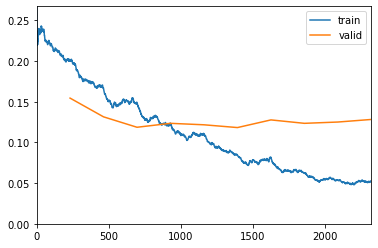

Better model found at epoch 1 with f1_score value: 0.8813939830175596.
Better model found at epoch 2 with f1_score value: 0.8900085633754575.
Better model found at epoch 4 with f1_score value: 0.8937559180606368.
Better model found at epoch 5 with f1_score value: 0.8955833673120638.
Better model found at epoch 7 with f1_score value: 0.8999174301508469.
Better model found at epoch 8 with f1_score value: 0.9024434121732998.
Better model found at epoch 9 with f1_score value: 0.9035537206514435.


In [19]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [20]:
learn.export('plant_resnet34_f1_540px.pkl') # save the model

In [21]:
learn = load_learner('plant_resnet34_f1_540px.pkl') # load the model

# resnet50

SuggestedLRs(valley=0.0014454397605732083)

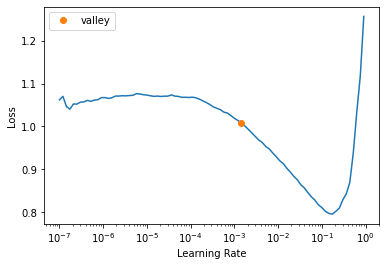

In [16]:
dls = dblock.dataloaders(df, bs=40)

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='f1_score',
                            fname='resnet50_f1_540px'
                     
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.604663,0.423970,0.687088,13:57
1,0.292714,0.203978,0.825605,13:51
2,0.210441,0.168562,0.854368,13:53
3,0.193099,0.140037,0.871917,13:53


Better model found at epoch 0 with f1_score value: 0.6870875066815169.


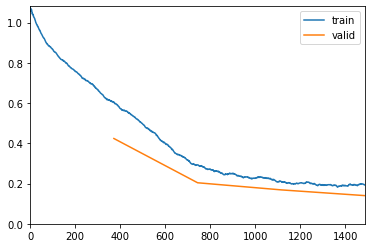

Better model found at epoch 1 with f1_score value: 0.825604839298989.
Better model found at epoch 2 with f1_score value: 0.8543678865207801.
Better model found at epoch 3 with f1_score value: 0.8719174420952982.


epoch,train_loss,valid_loss,f1_score,time
0,0.154491,0.122275,0.893318,17:45
1,0.138860,0.122487,0.886759,17:44
2,0.132469,0.114691,0.887345,17:44
3,0.122051,0.107054,0.902381,17:44
4,0.106289,0.100678,0.911316,17:43
5,0.090292,0.105979,0.910096,17:42
6,0.076329,0.112382,0.910500,17:43
7,0.054800,0.116587,0.912690,17:45
8,0.042848,0.117002,0.913720,17:43
9,0.039038,0.113535,0.914167,17:43


Better model found at epoch 0 with f1_score value: 0.8933177513629992.


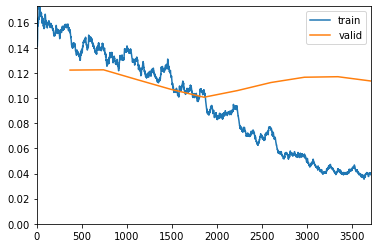

Better model found at epoch 3 with f1_score value: 0.9023811102104287.
Better model found at epoch 4 with f1_score value: 0.9113162934446102.
Better model found at epoch 7 with f1_score value: 0.9126898461953341.
Better model found at epoch 8 with f1_score value: 0.9137204526945695.
Better model found at epoch 9 with f1_score value: 0.9141668676830303.


In [17]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [18]:
learn.export('plant_resnet50_f1_540px.pkl') # save the model

In [19]:
learn = load_learner('plant_resnet50_f1_540px.pkl') # load the model

# resnet101

SuggestedLRs(valley=0.0020892962347716093)

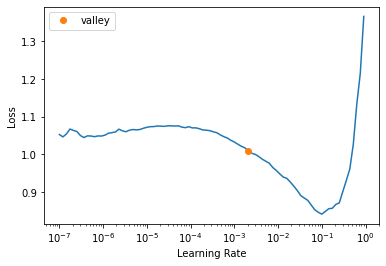

In [20]:
dls = dblock.dataloaders(df, bs=26)

learn = cnn_learner(dls,
                    arch=resnet101,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='f1_score',
                            fname='resnet101_f1_540px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.461612,0.309265,0.774800,19:52
1,0.235394,0.170932,0.842349,20:24
2,0.190667,0.141315,0.871414,20:26
3,0.162768,0.128442,0.890270,20:18


Better model found at epoch 0 with f1_score value: 0.7748000160858084.


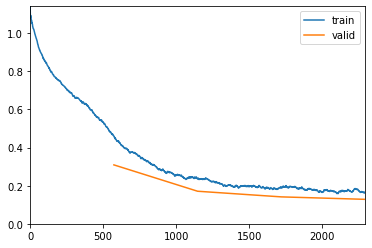

Better model found at epoch 1 with f1_score value: 0.842348992884867.
Better model found at epoch 2 with f1_score value: 0.8714137080690424.
Better model found at epoch 3 with f1_score value: 0.890269602891258.


epoch,train_loss,valid_loss,f1_score,time
0,0.165347,0.130827,0.878313,26:00
1,0.156381,0.121794,0.879154,25:56
2,0.159382,0.133386,0.880551,25:58
3,0.137792,0.114909,0.895195,25:56
4,0.123145,0.102915,0.899582,25:58
5,0.110969,0.099850,0.905592,25:57
6,0.091390,0.094406,0.916178,25:58
7,0.069128,0.100572,0.916009,25:58
8,0.063720,0.103151,0.917592,25:58
9,0.058078,0.101986,0.916099,25:57


Better model found at epoch 0 with f1_score value: 0.8783132253343259.


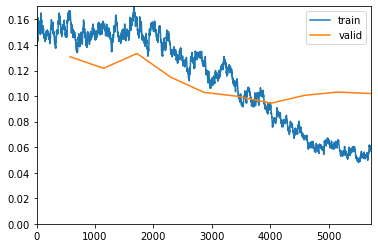

Better model found at epoch 1 with f1_score value: 0.8791535896977133.
Better model found at epoch 2 with f1_score value: 0.8805514689080446.
Better model found at epoch 3 with f1_score value: 0.8951948781804099.
Better model found at epoch 4 with f1_score value: 0.8995819480983864.
Better model found at epoch 5 with f1_score value: 0.9055922837879997.
Better model found at epoch 6 with f1_score value: 0.9161782299639281.
Better model found at epoch 8 with f1_score value: 0.9175920325170506.


In [21]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [22]:
learn.export('plant_resnet101_f1_540px.pkl') # save the model

In [23]:
learn = load_learner('plant_resnet101_f1_540px.pkl') # load the model

# resnet152

SuggestedLRs(valley=0.0012022644514217973)

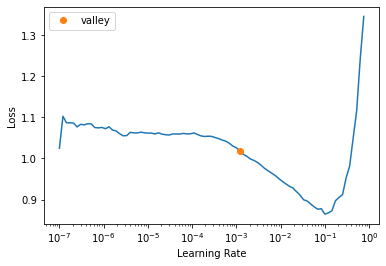

In [14]:
dls = dblock.dataloaders(df, bs=20)

learn = cnn_learner(dls,
                    arch=resnet152,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='f1_score',
                            fname='resnet152_f1_540px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.536649,0.368459,0.724680,28:57
1,0.264590,0.181350,0.829699,28:48
2,0.204061,0.144357,0.860442,28:49
3,0.178313,0.129189,0.881720,28:50


Better model found at epoch 0 with f1_score value: 0.7246797414268973.


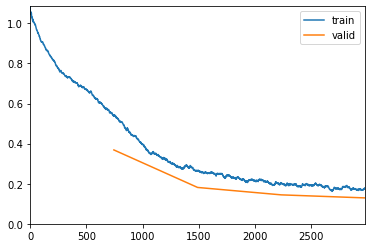

Better model found at epoch 1 with f1_score value: 0.829698990712981.
Better model found at epoch 2 with f1_score value: 0.860441827564673.
Better model found at epoch 3 with f1_score value: 0.8817203109385193.


epoch,train_loss,valid_loss,f1_score,time
0,0.164408,0.122040,0.881605,37:34
1,0.155173,0.131068,0.869008,37:34
2,0.147921,0.118373,0.889123,37:34
3,0.141401,0.103823,0.905641,37:34
4,0.118088,0.114225,0.891380,37:34
5,0.114088,0.100922,0.911078,37:35
6,0.078346,0.105768,0.907473,37:34
7,0.058880,0.114032,0.904864,37:34
8,0.046586,0.110952,0.911708,37:34
9,0.044491,0.115597,0.911846,37:33


Better model found at epoch 0 with f1_score value: 0.8816046260874355.


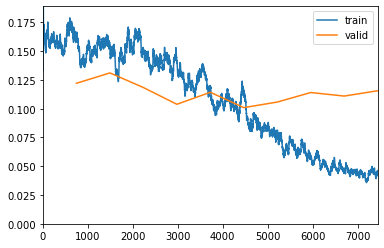

Better model found at epoch 2 with f1_score value: 0.8891225916434881.
Better model found at epoch 3 with f1_score value: 0.905641358548517.
Better model found at epoch 5 with f1_score value: 0.9110780568869377.
Better model found at epoch 8 with f1_score value: 0.9117079794481389.
Better model found at epoch 9 with f1_score value: 0.9118460508667741.


In [15]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [16]:
learn.export('plant_resnet152_f1_540px.pkl') # save the model

In [17]:
learn = load_learner('plant_resnet152_f1_540px.pkl') # load the model

# valid_loss 480 px

# resnet18

SuggestedLRs(valley=0.0030199517495930195)

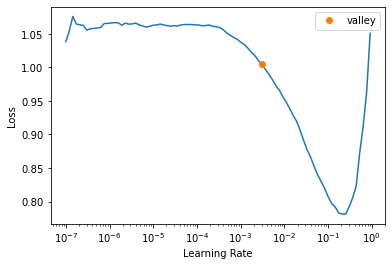

In [18]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(480, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=80)

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet18_vl_480px'
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.688449,0.473944,0.645653,11:40
1,0.344590,0.238915,0.794967,11:37
2,0.239264,0.194882,0.844117,11:37
3,0.208319,0.167353,0.849400,11:35


Better model found at epoch 0 with valid_loss value: 0.47394439578056335.


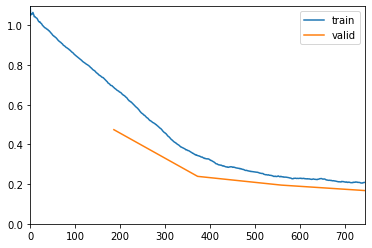

Better model found at epoch 1 with valid_loss value: 0.2389148473739624.
Better model found at epoch 2 with valid_loss value: 0.19488166272640228.
Better model found at epoch 3 with valid_loss value: 0.16735315322875977.


epoch,train_loss,valid_loss,f1_score,time
0,0.163679,0.144067,0.865504,11:43
1,0.151319,0.132547,0.879382,11:42
2,0.137528,0.142282,0.876169,11:44
3,0.121005,0.125081,0.890597,11:42
4,0.104669,0.128573,0.887861,11:42
5,0.083630,0.121098,0.899231,11:41
6,0.067145,0.121507,0.902089,11:42
7,0.054342,0.121841,0.907826,11:38
8,0.043036,0.121492,0.908039,11:42
9,0.039249,0.122715,0.907530,11:39


Better model found at epoch 0 with valid_loss value: 0.1440671682357788.


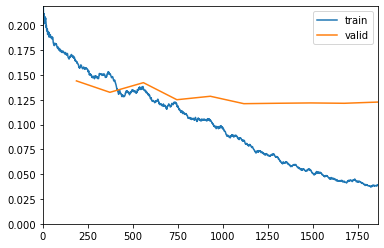

Better model found at epoch 1 with valid_loss value: 0.13254696130752563.
Better model found at epoch 3 with valid_loss value: 0.12508077919483185.
Better model found at epoch 5 with valid_loss value: 0.12109801173210144.


In [19]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [20]:
learn.export('plant_resnet18_vl_480px.pkl') # save the model

In [21]:
learn = load_learner('plant_resnet18_vl_480px.pkl') # load the model

# valid_loss 480px

## resnet34

SuggestedLRs(valley=0.0010000000474974513)

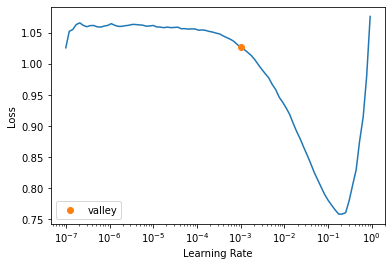

In [14]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(480, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=116)

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet34_vl_480px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.888356,0.625274,0.539857,12:02
1,0.644647,0.428535,0.682087,12:18
2,0.404342,0.256599,0.790570,12:22
3,0.278527,0.208020,0.807348,12:22


Better model found at epoch 0 with valid_loss value: 0.6252739429473877.


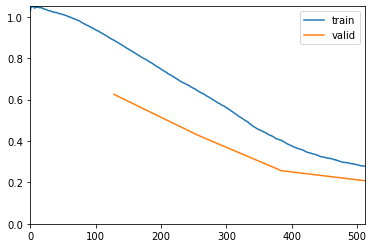

Better model found at epoch 1 with valid_loss value: 0.4285351634025574.
Better model found at epoch 2 with valid_loss value: 0.25659865140914917.
Better model found at epoch 3 with valid_loss value: 0.20802031457424164.


epoch,train_loss,valid_loss,f1_score,time
0,0.215059,0.162273,0.850459,12:37
1,0.172986,0.141752,0.864230,12:33
2,0.145975,0.129791,0.884045,12:42
3,0.123404,0.122695,0.892802,12:38
4,0.106812,0.127069,0.883686,12:36
5,0.089634,0.123221,0.896291,12:37
6,0.074211,0.124084,0.902621,12:36
7,0.062155,0.123543,0.899805,12:32
8,0.054647,0.125635,0.902708,12:32
9,0.052641,0.125690,0.902517,12:33


Better model found at epoch 0 with valid_loss value: 0.16227304935455322.


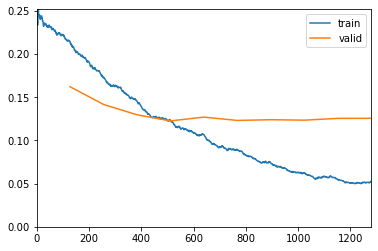

Better model found at epoch 1 with valid_loss value: 0.14175204932689667.
Better model found at epoch 2 with valid_loss value: 0.12979073822498322.
Better model found at epoch 3 with valid_loss value: 0.12269510328769684.


In [15]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [16]:
learn.export('plant_resnet34_vl_480px.pkl') # save the model

In [17]:
learn = load_learner('plant_resnet34_vl_480px.pkl') # load the model

# valid_loss 480px

## resnet50

SuggestedLRs(valley=0.0010000000474974513)

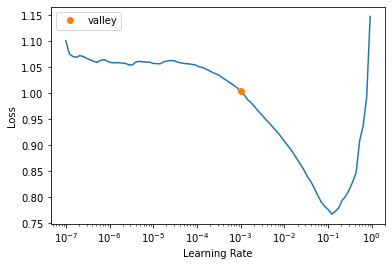

In [14]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(480, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=50)

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet50_vl_480px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.669549,0.477410,0.648266,12:52
1,0.390828,0.259034,0.810413,12:43
2,0.242567,0.182070,0.828776,12:41
3,0.193297,0.157256,0.856674,12:40


Better model found at epoch 0 with valid_loss value: 0.47740963101387024.


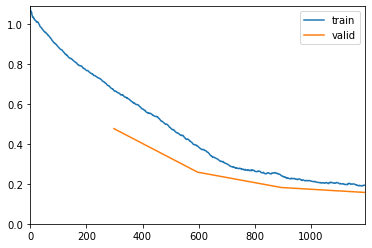

Better model found at epoch 1 with valid_loss value: 0.2590338885784149.
Better model found at epoch 2 with valid_loss value: 0.18206970393657684.
Better model found at epoch 3 with valid_loss value: 0.15725605189800262.


epoch,train_loss,valid_loss,f1_score,time
0,0.161238,0.134286,0.875027,14:10
1,0.142517,0.123508,0.881995,14:08
2,0.130629,0.114812,0.893001,14:08
3,0.116866,0.113656,0.900075,14:08
4,0.104143,0.104640,0.908700,14:09
5,0.084247,0.116040,0.905866,14:08
6,0.070576,0.108808,0.911978,14:09
7,0.051995,0.114891,0.909475,14:08
8,0.044239,0.117840,0.910888,14:08
9,0.040874,0.119192,0.910476,14:10


Better model found at epoch 0 with valid_loss value: 0.1342860609292984.


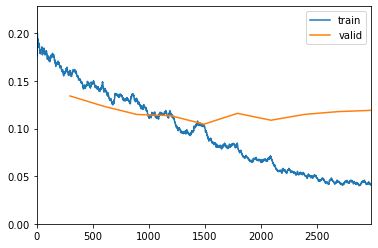

Better model found at epoch 1 with valid_loss value: 0.1235080435872078.
Better model found at epoch 2 with valid_loss value: 0.1148119792342186.
Better model found at epoch 3 with valid_loss value: 0.11365647614002228.
Better model found at epoch 4 with valid_loss value: 0.10464001446962357.


In [15]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [16]:
learn.export('plant_resnet50_vl_480px.pkl') # save the model

In [17]:
learn = load_learner('plant_resnet50_vl_480px.pkl') # load the model

## resnet101

SuggestedLRs(valley=0.0010000000474974513)

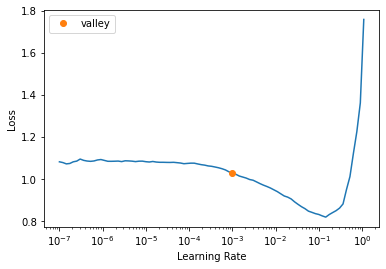

In [14]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(480, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=32)

learn = cnn_learner(dls,
                    arch=resnet101,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet101_vl_480px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.604862,0.439450,0.672636,15:15
1,0.313218,0.214879,0.821914,15:10
2,0.214673,0.164451,0.855274,16:08
3,0.175474,0.141056,0.872278,15:14


Better model found at epoch 0 with valid_loss value: 0.4394496977329254.


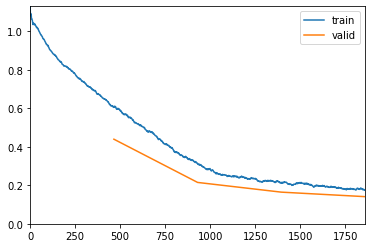

Better model found at epoch 1 with valid_loss value: 0.2148788720369339.
Better model found at epoch 2 with valid_loss value: 0.164450541138649.
Better model found at epoch 3 with valid_loss value: 0.141056090593338.


epoch,train_loss,valid_loss,f1_score,time
0,0.154058,0.117445,0.891691,19:10
1,0.138955,0.122525,0.883487,19:08
2,0.136147,0.122428,0.886409,19:09
3,0.126455,0.109248,0.904517,19:10
4,0.104875,0.106088,0.903864,19:11
5,0.085359,0.103622,0.910279,19:09
6,0.064120,0.116282,0.905515,19:10
7,0.057263,0.119206,0.911792,19:10
8,0.042220,0.125415,0.911187,19:10
9,0.037444,0.120650,0.914872,19:09


Better model found at epoch 0 with valid_loss value: 0.11744479089975357.


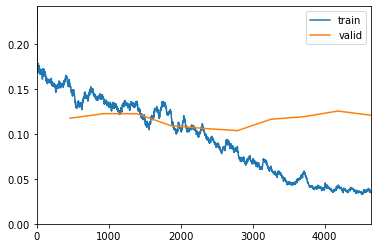

Better model found at epoch 3 with valid_loss value: 0.10924782603979111.
Better model found at epoch 4 with valid_loss value: 0.10608828812837601.
Better model found at epoch 5 with valid_loss value: 0.10362163931131363.


In [15]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [16]:
learn.export('plant_resnet101_vl_480px.pkl') # save the model

In [17]:
learn = load_learner('plant_resnet101_vl_480px.pkl') # load the model

## resnet152

SuggestedLRs(valley=0.002511886414140463)

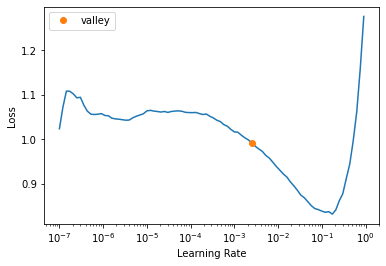

In [14]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(480, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=24)

learn = cnn_learner(dls,
                    arch=resnet152,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet152_vl_480px'
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.417467,0.274906,0.806951,22:38
1,0.226772,0.164137,0.854147,23:03
2,0.187988,0.133868,0.874799,23:01
3,0.158574,0.122767,0.884992,22:33


Better model found at epoch 0 with valid_loss value: 0.27490589022636414.


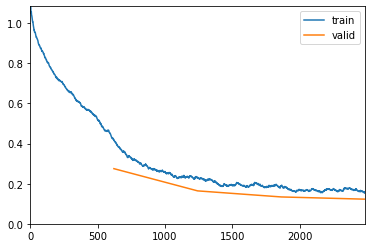

Better model found at epoch 1 with valid_loss value: 0.16413691639900208.
Better model found at epoch 2 with valid_loss value: 0.13386836647987366.
Better model found at epoch 3 with valid_loss value: 0.1227668896317482.


epoch,train_loss,valid_loss,f1_score,time
0,0.154541,0.120537,0.889207,28:44
1,0.165250,0.143876,0.868185,28:42
2,0.149410,0.139234,0.855904,28:42
3,0.148654,0.113082,0.885129,28:42
4,0.131850,0.108214,0.890586,28:42
5,0.117498,0.111410,0.896263,28:40
6,0.094389,0.103762,0.901894,28:40
7,0.083509,0.094354,0.916884,28:41
8,0.072373,0.101146,0.916655,28:41
9,0.065945,0.101614,0.914773,28:41


Better model found at epoch 0 with valid_loss value: 0.12053656578063965.


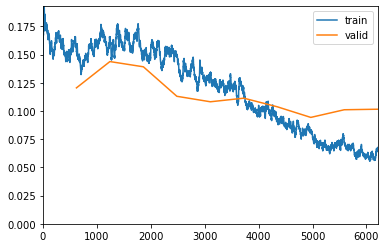

Better model found at epoch 3 with valid_loss value: 0.11308199912309647.
Better model found at epoch 4 with valid_loss value: 0.10821399837732315.
Better model found at epoch 6 with valid_loss value: 0.10376177728176117.
Better model found at epoch 7 with valid_loss value: 0.09435352683067322.


In [15]:
learn.fine_tune(10, base_lr=lrMin.valley, freeze_epochs=4)

In [16]:
learn.export('plant_resnet152_vl_480px.pkl') # save the model

In [18]:
learn = load_learner('plant_resnet152_vl_480px.pkl') # load the model

# valid_loss 224px

## resnet18

SuggestedLRs(valley=0.0020892962347716093)

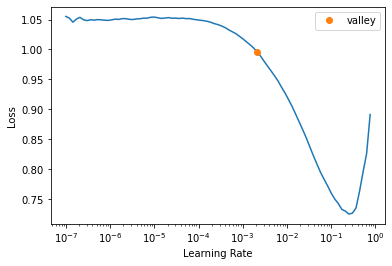

In [16]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(224, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=248)

monitor='valid_loss'

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.835690,0.529661,0.611344,11:32
1,0.551072,0.288011,0.770360,11:30


Better model found at epoch 0 with valid_loss value: 0.5296614170074463.


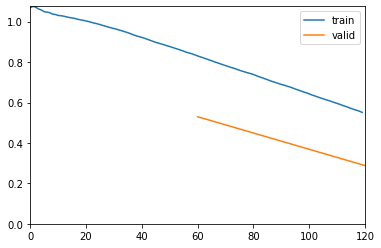

Better model found at epoch 1 with valid_loss value: 0.28801101446151733.


epoch,train_loss,valid_loss,f1_score,time
0,0.293129,0.226864,0.806801,11:36
1,0.246483,0.192630,0.827863,11:38
2,0.207704,0.171275,0.843123,11:38
3,0.180446,0.157669,0.848102,11:37
4,0.156548,0.149804,0.856360,11:37
5,0.135527,0.149380,0.869021,11:38
6,0.120480,0.143874,0.877956,11:38
7,0.105298,0.151062,0.875572,11:39
8,0.092864,0.157030,0.877213,11:41
9,0.082374,0.160395,0.883277,11:39


Better model found at epoch 0 with valid_loss value: 0.2268643081188202.


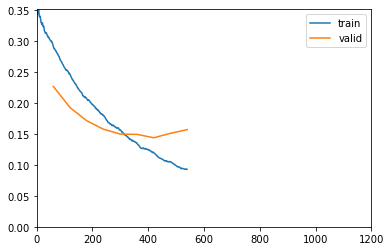

Better model found at epoch 1 with valid_loss value: 0.19262969493865967.
Better model found at epoch 2 with valid_loss value: 0.1712745577096939.
Better model found at epoch 3 with valid_loss value: 0.1576693207025528.
Better model found at epoch 4 with valid_loss value: 0.1498042494058609.
Better model found at epoch 5 with valid_loss value: 0.14937995374202728.
Better model found at epoch 6 with valid_loss value: 0.14387372136116028.
No improvement since epoch 6: early stopping


In [17]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2)

In [18]:
learn.export('plant_resnet18_vl_224px.pkl') # save the model

In [19]:
learn = load_learner('plant_resnet18_vl_224px.pkl') # load the model

## resnet34

SuggestedLRs(valley=0.0010000000474974513)

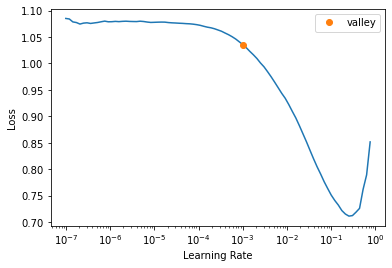

In [14]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(224, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=416)

monitor='valid_loss'

learn = cnn_learner(dls,
                    arch=resnet34,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet34_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.972008,0.659293,0.521608,12:47
1,0.783179,0.488815,0.638399,13:09


Better model found at epoch 0 with valid_loss value: 0.6592929363250732.


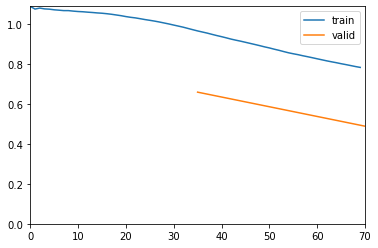

Better model found at epoch 1 with valid_loss value: 0.48881515860557556.


epoch,train_loss,valid_loss,f1_score,time
0,0.550057,0.421989,0.690759,13:14
1,0.495214,0.353355,0.746472,13:05
2,0.426160,0.281698,0.803549,12:54
3,0.353779,0.234002,0.837170,13:16
4,0.291493,0.197190,0.857770,13:09
5,0.241207,0.177588,0.865645,12:19
6,0.201225,0.163011,0.870736,11:51
7,0.170142,0.158770,0.872798,11:57
8,0.147468,0.157950,0.872124,11:59
9,0.129102,0.158511,0.874704,11:53


Better model found at epoch 0 with valid_loss value: 0.42198947072029114.


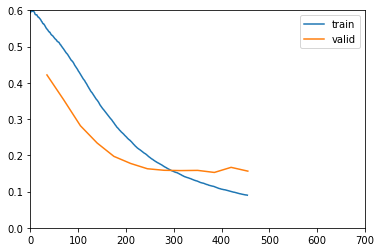

Better model found at epoch 1 with valid_loss value: 0.35335466265678406.
Better model found at epoch 2 with valid_loss value: 0.28169840574264526.
Better model found at epoch 3 with valid_loss value: 0.23400171101093292.
Better model found at epoch 4 with valid_loss value: 0.1971898376941681.
Better model found at epoch 5 with valid_loss value: 0.17758847773075104.
Better model found at epoch 6 with valid_loss value: 0.16301073133945465.
Better model found at epoch 7 with valid_loss value: 0.15877044200897217.
Better model found at epoch 8 with valid_loss value: 0.1579500287771225.
Better model found at epoch 10 with valid_loss value: 0.15279556810855865.
No improvement since epoch 10: early stopping


In [15]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2)

In [16]:
learn.export('plant_resnet34_vl_224px.pkl') # save the model

In [17]:
learn = load_learner('plant_resnet34_vl_224px.pkl') # load the model

## resnet50

SuggestedLRs(valley=0.0005754399462603033)

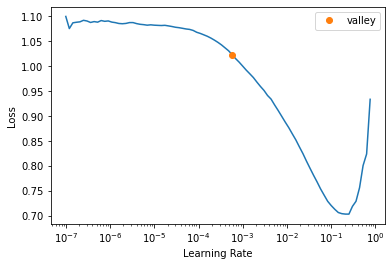

In [18]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(224, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=220)

monitor='valid_loss'

learn = cnn_learner(dls,
                    arch=resnet50,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet50_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.851642,0.564331,0.597259,11:33
1,0.640393,0.418909,0.689289,11:17


Better model found at epoch 0 with valid_loss value: 0.5643313527107239.


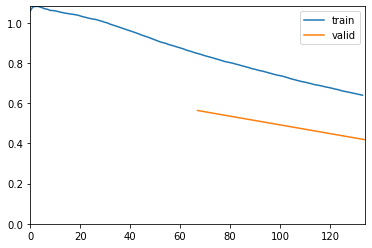

Better model found at epoch 1 with valid_loss value: 0.41890931129455566.


epoch,train_loss,valid_loss,f1_score,time
0,0.464329,0.355781,0.745814,11:22
1,0.402448,0.300189,0.795421,11:26
2,0.336185,0.246848,0.835848,11:23
3,0.276512,0.206693,0.858095,11:26
4,0.226775,0.178443,0.873580,11:28
5,0.188912,0.156740,0.881162,11:27
6,0.161100,0.149970,0.881710,11:28
7,0.138349,0.142592,0.880945,11:27
8,0.122002,0.140398,0.879509,11:29
9,0.108956,0.140155,0.883549,11:29


Better model found at epoch 0 with valid_loss value: 0.35578057169914246.


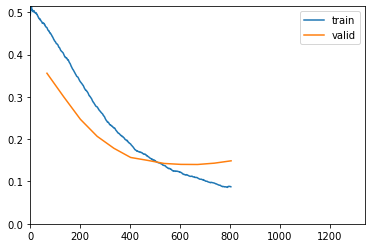

Better model found at epoch 1 with valid_loss value: 0.3001886010169983.
Better model found at epoch 2 with valid_loss value: 0.2468475103378296.
Better model found at epoch 3 with valid_loss value: 0.20669306814670563.
Better model found at epoch 4 with valid_loss value: 0.1784428358078003.
Better model found at epoch 5 with valid_loss value: 0.15673959255218506.
Better model found at epoch 6 with valid_loss value: 0.14996974170207977.
Better model found at epoch 7 with valid_loss value: 0.14259196817874908.
Better model found at epoch 8 with valid_loss value: 0.14039838314056396.
Better model found at epoch 9 with valid_loss value: 0.1401546448469162.
No improvement since epoch 9: early stopping


In [19]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2)

In [20]:
learn.export('plant_resnet50_vl_224px.pkl') # save the model

In [21]:
learn = load_learner('plant_resnet50_vl_224px.pkl') # load the model

## resnet101

SuggestedLRs(valley=0.0010000000474974513)

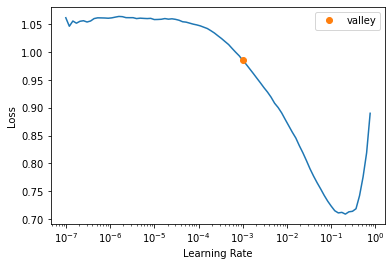

In [22]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(224, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=144)

monitor='valid_loss'

learn = cnn_learner(dls,
                    arch=resnet101,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet101_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.730618,0.477641,0.652321,11:46
1,0.452777,0.269222,0.808139,11:50


Better model found at epoch 0 with valid_loss value: 0.47764113545417786.


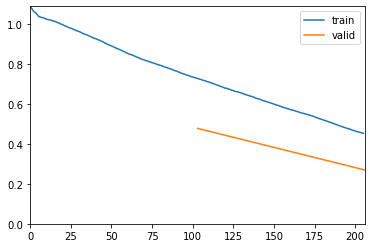

Better model found at epoch 1 with valid_loss value: 0.2692224979400635.


epoch,train_loss,valid_loss,f1_score,time
0,0.272770,0.198759,0.852870,11:59
1,0.215099,0.165542,0.866100,11:56
2,0.178111,0.142410,0.873365,11:54
3,0.142883,0.140069,0.884068,11:56
4,0.123424,0.135758,0.883332,11:59
5,0.108257,0.136181,0.892769,11:55
6,0.087313,0.149221,0.878759,11:57
7,0.077102,0.149627,0.882700,11:55


Better model found at epoch 0 with valid_loss value: 0.19875910878181458.


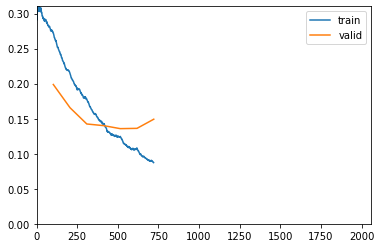

Better model found at epoch 1 with valid_loss value: 0.16554221510887146.
Better model found at epoch 2 with valid_loss value: 0.1424100250005722.
Better model found at epoch 3 with valid_loss value: 0.14006857573986053.
Better model found at epoch 4 with valid_loss value: 0.13575764000415802.
No improvement since epoch 4: early stopping


In [23]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2)

In [24]:
learn.export('plant_resnet101_vl_224px.pkl') # save the model

In [25]:
learn = load_learner('plant_resnet101_vl_224px.pkl') # load the model

## resnset152

SuggestedLRs(valley=0.0005754399462603033)

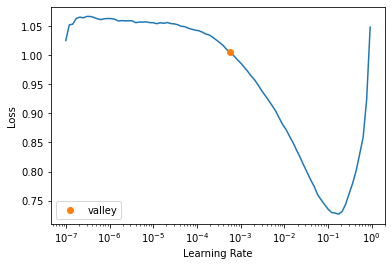

In [26]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=RandomResizedCrop(224, min_scale=0.35)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=104)

monitor='valid_loss'

learn = cnn_learner(dls,
                    arch=resnet152,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor='valid_loss',
                            fname='resnet152_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   ).to_fp16()

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.751244,0.508312,0.635702,11:55
1,0.487223,0.306273,0.781741,11:52


Better model found at epoch 0 with valid_loss value: 0.5083118081092834.


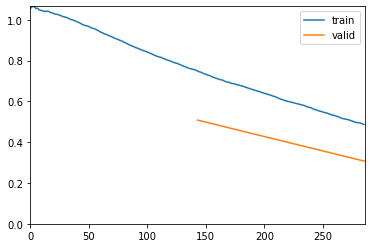

Better model found at epoch 1 with valid_loss value: 0.3062727153301239.


epoch,train_loss,valid_loss,f1_score,time
0,0.329205,0.233729,0.840902,12:06
1,0.261263,0.190873,0.864816,12:05
2,0.206503,0.159556,0.875918,12:03
3,0.172288,0.139131,0.887565,12:06
4,0.138550,0.127633,0.887752,12:07
5,0.120290,0.128620,0.888299,12:06
6,0.101352,0.128864,0.890106,12:07
7,0.092968,0.133192,0.891741,12:06


Better model found at epoch 0 with valid_loss value: 0.23372922837734222.


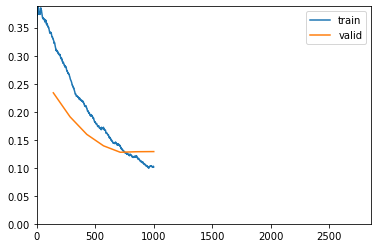

Better model found at epoch 1 with valid_loss value: 0.1908729076385498.
Better model found at epoch 2 with valid_loss value: 0.15955635905265808.
Better model found at epoch 3 with valid_loss value: 0.13913092017173767.
Better model found at epoch 4 with valid_loss value: 0.1276329606771469.
No improvement since epoch 4: early stopping


In [27]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2)

In [28]:
learn.export('plant_resnet152_vl_224px.pkl') # save the model

In [29]:
learn = load_learner('plant_resnet152_vl_224px.pkl') # load the model

## resnet18 test presizing

/home/xar/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.001737800776027143)

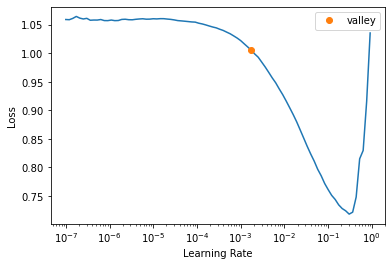

In [15]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(540),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=248)

monitor='valid_loss'

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.856507,0.554280,0.596937,12:07
1,0.586696,0.309403,0.762227,12:03


Better model found at epoch 0 with valid_loss value: 0.5542795062065125.


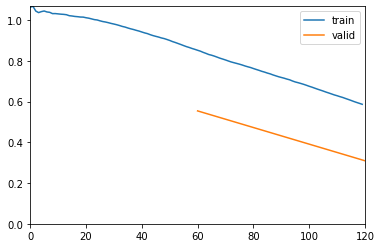

Better model found at epoch 1 with valid_loss value: 0.3094027638435364.


epoch,train_loss,valid_loss,f1_score,time
0,0.328275,0.244900,0.808314,12:02
1,0.275071,0.201600,0.828965,12:01
2,0.233418,0.174817,0.846743,12:01
3,0.198315,0.157476,0.853327,12:00
4,0.172250,0.147817,0.867060,12:01
5,0.152745,0.141643,0.873435,11:56
6,0.140073,0.135895,0.878440,11:59
7,0.128409,0.133755,0.884255,12:00
8,0.116507,0.138186,0.876740,12:33
9,0.106364,0.133998,0.884748,12:39


Better model found at epoch 0 with valid_loss value: 0.24489974975585938.


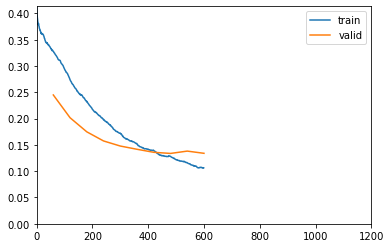

Better model found at epoch 1 with valid_loss value: 0.2015998214483261.
Better model found at epoch 2 with valid_loss value: 0.1748172640800476.
Better model found at epoch 3 with valid_loss value: 0.1574764847755432.
Better model found at epoch 4 with valid_loss value: 0.14781694114208221.
Better model found at epoch 5 with valid_loss value: 0.14164289832115173.
Better model found at epoch 6 with valid_loss value: 0.1358954906463623.
Better model found at epoch 7 with valid_loss value: 0.13375471532344818.
No improvement since epoch 7: early stopping


In [16]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2)

# 224 Practice

## resnet18 wd practice 0.1

SuggestedLRs(valley=0.001737800776027143)

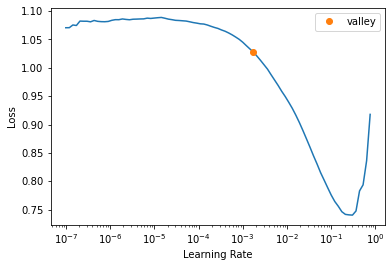

In [17]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(540),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=248)

monitor='valid_loss'
wd = 0.1

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.870680,0.543493,0.606329,12:26
1,0.598184,0.306459,0.769633,12:13


Better model found at epoch 0 with valid_loss value: 0.5434925556182861.


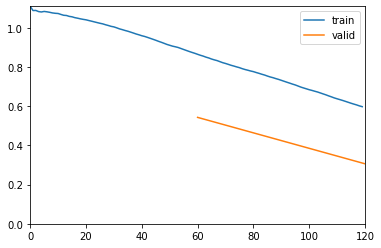

Better model found at epoch 1 with valid_loss value: 0.3064585328102112.


epoch,train_loss,valid_loss,f1_score,time
0,0.333248,0.239975,0.821184,12:11
1,0.279955,0.199619,0.838231,12:11
2,0.236802,0.171393,0.854308,12:07
3,0.201893,0.150654,0.862667,12:08
4,0.176306,0.145744,0.869407,12:03
5,0.157522,0.138093,0.869441,12:05
6,0.141732,0.142992,0.877985,12:01
7,0.127441,0.127735,0.881728,12:09
8,0.118223,0.130025,0.889954,12:09
9,0.105356,0.130745,0.889035,12:04


Better model found at epoch 0 with valid_loss value: 0.2399749457836151.


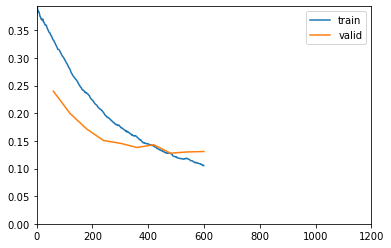

Better model found at epoch 1 with valid_loss value: 0.19961872696876526.
Better model found at epoch 2 with valid_loss value: 0.17139305174350739.
Better model found at epoch 3 with valid_loss value: 0.1506539136171341.
Better model found at epoch 4 with valid_loss value: 0.14574366807937622.
Better model found at epoch 5 with valid_loss value: 0.13809308409690857.
Better model found at epoch 7 with valid_loss value: 0.12773482501506805.
No improvement since epoch 7: early stopping


In [18]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

## resnet18 wd practice 0.2

/home/xar/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.001737800776027143)

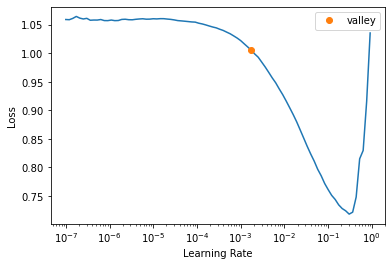

In [14]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(540),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=248)

monitor='valid_loss'
wd = 0.2

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.855880,0.553804,0.597123,12:02
1,0.585291,0.309586,0.762925,12:03


Better model found at epoch 0 with valid_loss value: 0.553803563117981.


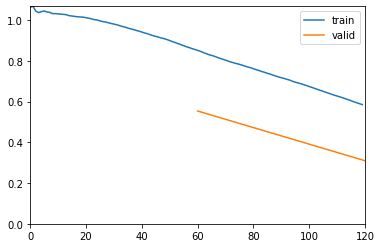

Better model found at epoch 1 with valid_loss value: 0.30958643555641174.


epoch,train_loss,valid_loss,f1_score,time
0,0.327010,0.245070,0.809271,13:06
1,0.274062,0.201669,0.828668,13:36
2,0.232519,0.174629,0.846587,12:59
3,0.197540,0.157387,0.853006,12:12
4,0.171584,0.147975,0.866467,12:15
5,0.152190,0.141537,0.872877,12:12
6,0.139474,0.135464,0.879150,12:11
7,0.128119,0.133555,0.884682,12:09
8,0.115938,0.137801,0.876360,12:16
9,0.105860,0.133868,0.883269,13:29


Better model found at epoch 0 with valid_loss value: 0.2450699359178543.


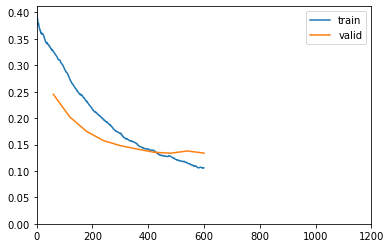

Better model found at epoch 1 with valid_loss value: 0.20166869461536407.
Better model found at epoch 2 with valid_loss value: 0.17462864518165588.
Better model found at epoch 3 with valid_loss value: 0.15738655626773834.
Better model found at epoch 4 with valid_loss value: 0.14797499775886536.
Better model found at epoch 5 with valid_loss value: 0.1415366232395172.
Better model found at epoch 6 with valid_loss value: 0.1354641169309616.
Better model found at epoch 7 with valid_loss value: 0.13355527818202972.
No improvement since epoch 7: early stopping


In [15]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

## resnet18 wd practice 0.3

SuggestedLRs(valley=0.001737800776027143)

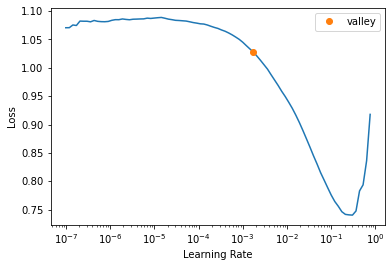

In [16]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(540),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=248)

monitor='valid_loss'
wd = 0.3

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.869999,0.542919,0.606460,13:10
1,0.596634,0.306672,0.769318,13:04


Better model found at epoch 0 with valid_loss value: 0.5429185628890991.


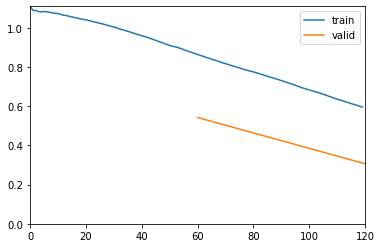

Better model found at epoch 1 with valid_loss value: 0.30667242407798767.


epoch,train_loss,valid_loss,f1_score,time
0,0.331827,0.240124,0.821486,13:10
1,0.278808,0.199567,0.838921,13:44
2,0.235824,0.171227,0.854601,13:40
3,0.201064,0.150533,0.862180,13:59
4,0.175645,0.145257,0.870693,12:20
5,0.156874,0.138109,0.869077,12:08
6,0.141062,0.142556,0.878375,12:08
7,0.126769,0.127483,0.880740,12:10
8,0.117308,0.129894,0.890441,12:10
9,0.104988,0.130760,0.887757,12:11


Better model found at epoch 0 with valid_loss value: 0.24012355506420135.


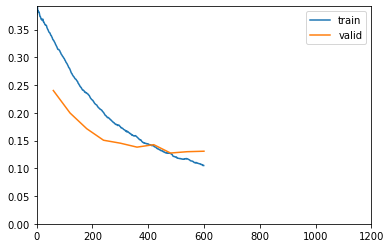

Better model found at epoch 1 with valid_loss value: 0.19956664741039276.
Better model found at epoch 2 with valid_loss value: 0.17122673988342285.
Better model found at epoch 3 with valid_loss value: 0.15053285658359528.
Better model found at epoch 4 with valid_loss value: 0.14525717496871948.
Better model found at epoch 5 with valid_loss value: 0.1381094753742218.
Better model found at epoch 7 with valid_loss value: 0.1274833083152771.
No improvement since epoch 7: early stopping


In [17]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

## resnet18 wd practice 0.4

SuggestedLRs(valley=0.0014454397605732083)

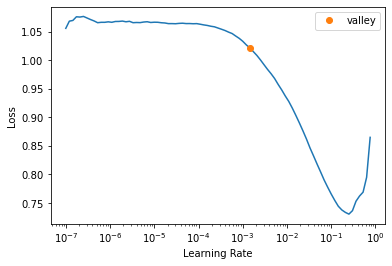

In [18]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(540),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=248)

monitor='valid_loss'
wd = 0.4

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_224px'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.877751,0.562272,0.588167,12:08
1,0.621701,0.336984,0.747360,12:07


Better model found at epoch 0 with valid_loss value: 0.5622717142105103.


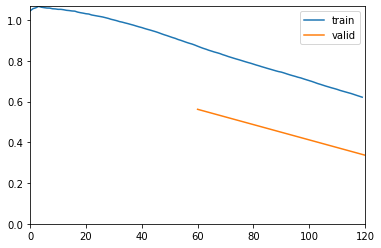

Better model found at epoch 1 with valid_loss value: 0.33698391914367676.


epoch,train_loss,valid_loss,f1_score,time
0,0.373424,0.272144,0.797896,12:07
1,0.315837,0.223640,0.827495,12:08
2,0.262193,0.185142,0.843307,12:07
3,0.220306,0.164146,0.857365,12:09
4,0.188313,0.148710,0.858496,12:10
5,0.166477,0.138968,0.877200,12:08
6,0.148763,0.133164,0.877118,12:13
7,0.134794,0.138365,0.879919,12:11
8,0.124252,0.129305,0.880324,12:13
9,0.114073,0.132505,0.881664,12:10


Better model found at epoch 0 with valid_loss value: 0.27214381098747253.


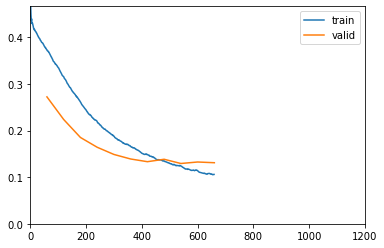

Better model found at epoch 1 with valid_loss value: 0.22364045679569244.
Better model found at epoch 2 with valid_loss value: 0.18514232337474823.
Better model found at epoch 3 with valid_loss value: 0.16414570808410645.
Better model found at epoch 4 with valid_loss value: 0.14871016144752502.
Better model found at epoch 5 with valid_loss value: 0.13896772265434265.
Better model found at epoch 6 with valid_loss value: 0.13316379487514496.
Better model found at epoch 8 with valid_loss value: 0.12930485606193542.
No improvement since epoch 8: early stopping


In [19]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

# 480 Practice

## resnet18 wd practice 0.1

SuggestedLRs(valley=0.002511886414140463)

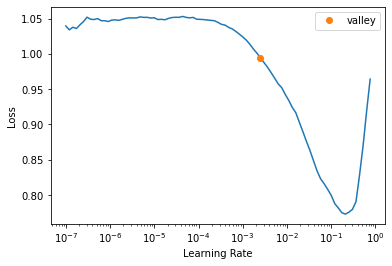

In [20]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(720),
    batch_tfms=aug_transforms(size=480, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=80)

monitor='valid_loss'
wd = 0.1

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_480px_wd0.1'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.595946,0.339282,0.747757,13:00
1,0.272570,0.197101,0.839638,13:00


Better model found at epoch 0 with valid_loss value: 0.3392815887928009.


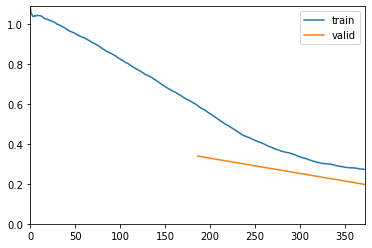

Better model found at epoch 1 with valid_loss value: 0.1971011459827423.


epoch,train_loss,valid_loss,f1_score,time
0,0.189236,0.151516,0.864685,13:11
1,0.162576,0.135469,0.877677,13:16
2,0.144732,0.128009,0.883875,13:18
3,0.136194,0.137702,0.881088,13:15
4,0.125917,0.124953,0.880288,13:12
5,0.112564,0.121737,0.891467,13:14
6,0.106465,0.116178,0.908194,13:15
7,0.100681,0.115816,0.902561,13:10
8,0.084369,0.123916,0.903882,13:15
9,0.077744,0.131591,0.888598,13:13


Better model found at epoch 0 with valid_loss value: 0.15151600539684296.


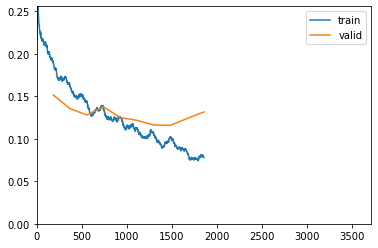

Better model found at epoch 1 with valid_loss value: 0.13546907901763916.
Better model found at epoch 2 with valid_loss value: 0.1280093938112259.
Better model found at epoch 4 with valid_loss value: 0.12495286762714386.
Better model found at epoch 5 with valid_loss value: 0.12173742800951004.
Better model found at epoch 6 with valid_loss value: 0.11617802828550339.
Better model found at epoch 7 with valid_loss value: 0.11581582576036453.
No improvement since epoch 7: early stopping


In [21]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

## resnet18 wd practice 0.2

SuggestedLRs(valley=0.0012022644514217973)

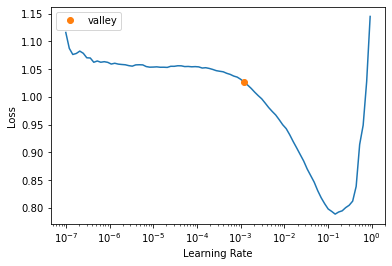

In [22]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(720),
    batch_tfms=aug_transforms(size=480, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=80)

monitor='valid_loss'
wd = 0.2

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_480px_wd0.2'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.720300,0.467066,0.643769,13:09
1,0.342698,0.239131,0.799017,13:14


Better model found at epoch 0 with valid_loss value: 0.4670656621456146.


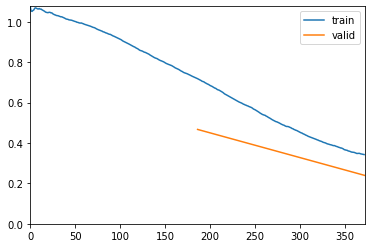

Better model found at epoch 1 with valid_loss value: 0.23913143575191498.


epoch,train_loss,valid_loss,f1_score,time
0,0.242601,0.186484,0.833604,13:16
1,0.197386,0.162037,0.852849,13:16
2,0.173302,0.145351,0.868441,13:15
3,0.147122,0.135788,0.876415,13:13
4,0.137791,0.129128,0.891891,13:12
5,0.121518,0.128637,0.887732,13:15
6,0.110116,0.126814,0.897207,13:13
7,0.102654,0.123276,0.900076,13:13
8,0.092502,0.127557,0.895116,13:13
9,0.081878,0.127956,0.899019,13:08


Better model found at epoch 0 with valid_loss value: 0.1864844113588333.


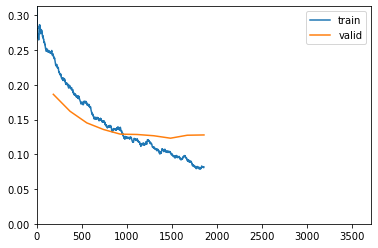

Better model found at epoch 1 with valid_loss value: 0.16203747689723969.
Better model found at epoch 2 with valid_loss value: 0.14535120129585266.
Better model found at epoch 3 with valid_loss value: 0.13578753173351288.
Better model found at epoch 4 with valid_loss value: 0.12912815809249878.
Better model found at epoch 5 with valid_loss value: 0.1286371648311615.
Better model found at epoch 6 with valid_loss value: 0.1268138885498047.
Better model found at epoch 7 with valid_loss value: 0.12327554076910019.
No improvement since epoch 7: early stopping


In [23]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

## resnet18 wd practice 0.3

SuggestedLRs(valley=0.0020892962347716093)

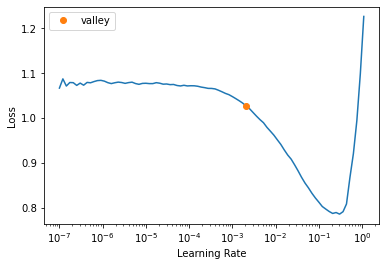

In [24]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(720),
    batch_tfms=aug_transforms(size=480, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=80)

monitor='valid_loss'
wd = 0.3

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_480px_wd0.3'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.627603,0.383447,0.719421,12:59
1,0.285821,0.206537,0.826177,12:57


Better model found at epoch 0 with valid_loss value: 0.38344720005989075.


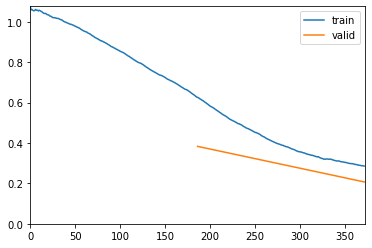

Better model found at epoch 1 with valid_loss value: 0.20653721690177917.


epoch,train_loss,valid_loss,f1_score,time
0,0.203231,0.157366,0.860080,13:09
1,0.169932,0.138410,0.873995,13:13
2,0.150969,0.130315,0.880473,13:02
3,0.131483,0.132260,0.882826,13:09
4,0.127912,0.132404,0.882287,13:06
5,0.118373,0.138730,0.884144,13:07


Better model found at epoch 0 with valid_loss value: 0.15736567974090576.


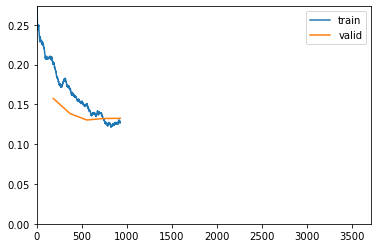

Better model found at epoch 1 with valid_loss value: 0.13841043412685394.
Better model found at epoch 2 with valid_loss value: 0.13031497597694397.
No improvement since epoch 2: early stopping


In [25]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)

## resnet18 wd practice 0.4

SuggestedLRs(valley=0.0014454397605732083)

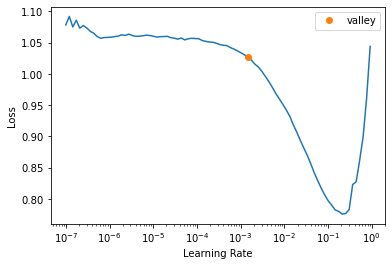

In [26]:
def get_x(df): return path/'train_images'/df['image']
def get_y(df): return df['labels']

dblock = DataBlock(
    blocks=[ImageBlock, MultiCategoryBlock],
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(valid_pct=valid_pct),
    item_tfms=Resize(720),
    batch_tfms=aug_transforms(size=480, min_scale=0.75)
)

loss_func = nn.BCEWithLogitsLoss()

dls = dblock.dataloaders(df, bs=80)

monitor='valid_loss'
wd = 0.4

learn = cnn_learner(dls,
                    arch=resnet18,
                    loss_func=loss_func,
                    metrics=F1ScoreMulti(thresh=0.5),
                    cbs=[
                        ShowGraphCallback(),
                        SaveModelCallback(
                            monitor=monitor,
                            fname='resnet18_vl_480px_wd0.4'
                        ),
                        EarlyStoppingCallback(
                            monitor=monitor,
                            patience=3
                        )
                    ]
                   )

lrMin = learn.lr_find()
lrMin

epoch,train_loss,valid_loss,f1_score,time
0,0.686333,0.439842,0.666133,13:05
1,0.326991,0.223059,0.808534,13:12


Better model found at epoch 0 with valid_loss value: 0.43984222412109375.


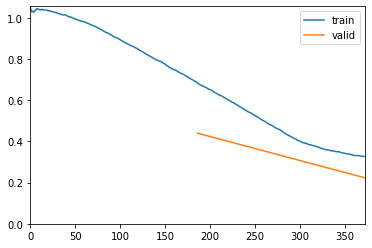

Better model found at epoch 1 with valid_loss value: 0.2230590432882309.


epoch,train_loss,valid_loss,f1_score,time
0,0.220339,0.171124,0.852354,14:14
1,0.182079,0.151326,0.864643,14:54
2,0.160630,0.139087,0.875544,15:19
3,0.145271,0.126432,0.888959,14:35
4,0.134119,0.126388,0.890604,13:32
5,0.115719,0.122866,0.884159,13:19
6,0.112983,0.122109,0.894917,13:14
7,0.100402,0.114057,0.901553,13:06
8,0.092809,0.120435,0.903792,13:06
9,0.079662,0.119270,0.903989,13:08


Better model found at epoch 0 with valid_loss value: 0.17112363874912262.


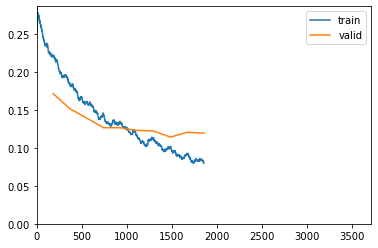

Better model found at epoch 1 with valid_loss value: 0.15132640302181244.
Better model found at epoch 2 with valid_loss value: 0.13908733427524567.
Better model found at epoch 3 with valid_loss value: 0.12643179297447205.
Better model found at epoch 4 with valid_loss value: 0.12638801336288452.
Better model found at epoch 5 with valid_loss value: 0.12286552041769028.
Better model found at epoch 6 with valid_loss value: 0.12210880219936371.
Better model found at epoch 7 with valid_loss value: 0.11405721306800842.
No improvement since epoch 7: early stopping


In [27]:
learn.fine_tune(20, base_lr=lrMin.valley, freeze_epochs=2, wd=wd)